# PDE-FIND for identifying Navier-Stokes

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND for the vorticity equation given a simulation of fluid flowing around a cylinder.
\begin{align*}
\omega_t &= \frac{1}{Re}\nabla^2 \omega - (V \cdot \nabla)\omega\\
V &= (v,u)\\
Re &= 100
\end{align*}
The x and y components of the velocity field are given as forcing terms to the PDE.  That is, they appear in $\Theta$, but are not differentiated.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data
steps = 151
n = 449
m = 199
U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

# Cut out the portion of the data before the cylinder
cut = True
xmin = 100
xmax = 425
ymin = 15
ymax = 185
# V2
xmax, ymax = xmax+1, ymax+1

# newcut: Cut out the portion of the data before the cylinder
# xmin = 80
# xmax = 450
# ymin = 0
# ymax = 200

if cut:
    W = W[xmin:xmax,ymin:ymax,:]
    U = U[xmin:xmax,ymin:ymax,:]
    V = V[xmin:xmax,ymin:ymax,:]

n,m,steps = W.shape

In [3]:
W = W.reshape(n*m,steps)
U = U.reshape(n*m,steps)
V = V.reshape(n*m,steps)

In [4]:
uw,sigmaw,vw = svd(W, full_matrices=False); vw = vw.T
uu,sigmau,vu = svd(U, full_matrices=False); vu = vu.T
uv,sigmav,vv = svd(V, full_matrices=False); vv = vv.T

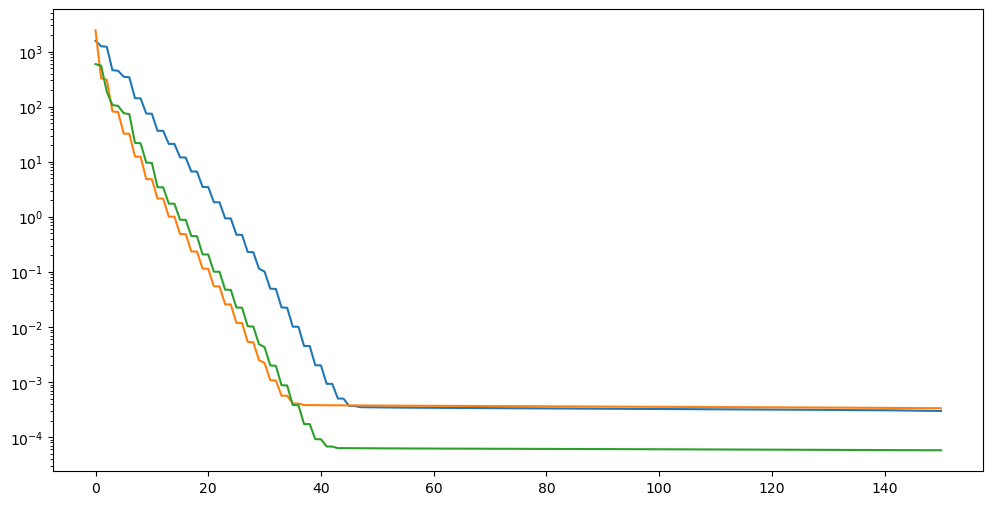

In [5]:
semilogy(sigmaw)
semilogy(sigmau)
semilogy(sigmav)

In [6]:
Wn = W.reshape(n,m,steps)
Un = U.reshape(n,m,steps)
Vn = V.reshape(n,m,steps)

In [7]:
# Sample a collection of data points, stay away from edges so I can just use centered finite differences.
np.random.seed(0)

num_xy = 5000
num_t = 60
num_points = num_xy * num_t
boundary = 5
boundary_x = 10
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary_x,n-boundary_x),1)[0]
    y = np.random.choice(np.arange(boundary,m-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,2*t+12]
        count = count + 1

In [8]:
# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

N = 2*boundary-1  # odd number of points to use in fitting
Nx = 2*boundary_x-1  # odd number of points to use in fitting
deg = 5 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    w[p] = Wn[x,y,t]
    u[p] = Un[x,y,t]
    v[p] = Vn[x,y,t]
    
    wt[p] = PolyDiffPoint(Wn[x,y,t-(N-1)//2:t+(N+1)//2], np.arange(N)*dt, deg, 1)[0]
    
    x_diff = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y,t], np.arange(Nx)*dx, deg, 2)
    y_diff = PolyDiffPoint(Wn[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    wx[p] = x_diff[0]
    wy[p] = y_diff[0]
    
    x_diff_yp = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y+1,t], np.arange(Nx)*dx, deg, 2)
    x_diff_ym = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y-1,t], np.arange(Nx)*dx, deg, 2)
    
    wxx[p] = x_diff[1]
    wxy[p] = (x_diff_yp[0]-x_diff_ym[0])/(2*dy)
    wyy[p] = y_diff[1]

In [9]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])

In [10]:
lam = 10**-5
d_tol = 5
c = TrainSTRidge(X,wt,lam,d_tol)
print_pde(c, description, ut = 'w_t')

l0_penalty: 1.7380138324983672
w_t = (0.009949 +0.000000i)w_{xx}
    + (0.009886 +0.000000i)w_{yy}
    + (-0.990411 +0.000000i)uw_{x}
    + (-0.986631 +0.000000i)vw_{y}
   


In [11]:
from misc import h5file
h5file('../Datasets/nv_originalV2_clean.h5', {'X':X, 'wt':wt}, mode='w')

(array([[ 1.00000000e+00+0.j,  8.81757412e-02+0.j,  5.65069341e-02+0.j,
         ...,  8.46601790e-04+0.j,  1.79712928e-03+0.j,
          2.59191747e-05+0.j],
        [ 1.00000000e+00+0.j, -2.45448910e-02+0.j,  2.33524103e-02+0.j,
         ...,  1.66713216e-04+0.j,  3.53510462e-04+0.j,
          2.09737709e-06+0.j],
        [ 1.00000000e+00+0.j, -1.62559789e-01+0.j,  1.15086379e-01+0.j,
         ...,  4.02485719e-03+0.j,  8.56657047e-03+0.j,
          2.32904611e-04+0.j],
        ...,
        [ 1.00000000e+00+0.j,  3.75538025e-02+0.j,  3.18186427e-01+0.j,
         ..., -1.34457438e-03+0.j,  1.09964423e-01+0.j,
         -2.33653188e-03+0.j],
        [ 1.00000000e+00+0.j, -1.24006655e-02+0.j,  7.55306680e-01+0.j,
         ...,  3.54990736e-02+0.j,  5.80462873e-01+0.j,
         -3.23828310e-02+0.j],
        [ 1.00000000e+00+0.j, -1.89506738e-01+0.j,  1.06737891e+00+0.j,
         ...,  1.27387360e-01+0.j,  1.04095244e+00+0.j,
         -9.36734602e-02+0.j]]),
 array([[-0.11582833],
        

In [12]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./"

from misc import h5file
import pickle
with open("../Datasets/nv_desc.pkl", "rb") as desc_fp:
    description = pickle.load(desc_fp)
ground_indices = (3, 5, 16, 24)
ground_coeffs = np.array([0.01, 0.01, -1, -1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [33]:
Xr, wtr = h5file("../Datasets/nv_clean.h5")
# Xr, wtr = h5file("../Datasets/nv_newcut_original_clean.h5")
Xr = Xr.real[:, 1:]
wtr = wtr.real
description = description[1:]

['X', 'wt']


In [34]:
combine = False
if not combine:
    newXr = Xr
else:
    # Combine features
    newXr = np.hstack((Xr, Xr[:, 2:3]+Xr[:, 4:5], Xr[:, 15:16]+Xr[:, 23:24]))
    description.append(f"{description[2]}+{description[4]}")
    description.append(f"{description[15]}+{description[23]}")
    newXr = np.delete(newXr, [2, 4, 15, 23], axis=1)
    print(description.pop(2))
    print(description.pop(4-1))
    print(description.pop(15-2))
    print(description.pop(23-3))

In [35]:
lam = 10**-5
d_tol = 5
c = TrainSTRidge(newXr,wtr,lam,d_tol)
print_pde(c, description, ut = 'w_t')

l0_penalty: 0.8419563843488794
w_t = (0.011051 +0.000000i)w_{xy}
    + (0.012470 +0.000000i)v
    + (-1.017017 +0.000000i)ww_{x}
    + (-1.006237 +0.000000i)uw_{y}
   


In [16]:
if not combine:
    errs = np.abs(c[nonz(c), :].real.ravel()-ground_coeffs)/np.abs(ground_coeffs)
    errs.mean(), errs.std()

In [17]:
lrs = []
ebics = []
eff_indices = []
max_complexity = 10
for s in range(1, max_complexity):
    lr = LinearRegression(support_size=s, ic_type='bic', always_select=None)
    lr.fit(newXr, wtr)
    lrs.append(lr)
    eff_indices.append(nonz(lr.coef_))
    ebics.append(lr.ic_)
    print(nonz(lr.coef_))
    print(lr.ic_)
abess_feature_hierarchy = set(eff_indices)

(0,)
-796427.2205235633
(0, 23)
-836586.6055949634
(4, 15, 23)
-1841687.5792230521
(2, 4, 15, 23)
-2029540.5710186984
(2, 4, 15, 23, 38)
-2054764.859675489
(2, 4, 15, 23, 38, 45)
-2074301.666054327
(2, 4, 15, 23, 38, 40, 45)
-2081515.1463659473
(2, 4, 5, 15, 23, 38, 40, 45)
-2088373.1216945727
(2, 4, 5, 15, 23, 37, 38, 40, 45)
-2092559.2794152587


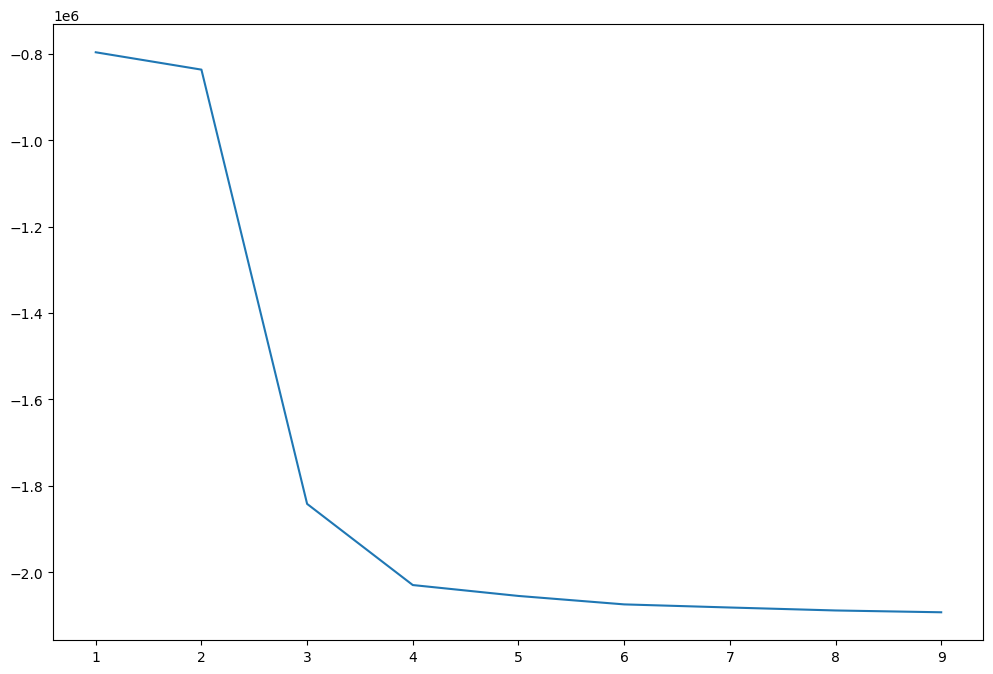

In [18]:
plt.plot([i for i in range(1, max_complexity)], ebics)
plt.show()

In [19]:
nor_axis = 0
if nor_axis is not None: Xfrols = normalize(newXr, axis=nor_axis)
else: Xfrols = newXr.copy()
frols_coeffs,selected_inds_list,_,_,_ = frols(wtr, Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0,),
 (0, 2, 4, 5, 15, 20, 23, 33, 38, 45),
 (0, 2, 4, 15, 20, 23),
 (0, 2, 4, 15, 20, 23, 33, 38, 45),
 (0, 2, 4, 15, 20, 23, 38),
 (0, 2, 4, 15, 20, 23, 38, 45),
 (0, 4, 15, 20, 23),
 (0, 15, 20),
 (0, 15, 20, 23),
 (0, 20)}

In [20]:
feature_hierarchy = abess_feature_hierarchy.union(selected_inds_list)

In [21]:
br1 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='k best', ic_type='bic', verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(0, 15, 20)
(0, 20)
(0,)
--------------------------------------------------
(2, 4, 5, 15, 23, 38, 40, 45)
(2, 4, 15, 23, 38, 40, 45)
(2, 4, 15, 23, 38, 45)
(2, 4, 15, 23, 38)
(2, 4, 15, 23)
(4, 15, 23)
(15, 23)
(15,)
--------------------------------------------------
(2, 4, 15, 23)
--------------------------------------------------
(0, 4, 15, 20, 23)
(0, 4, 15, 23)
(4, 15, 23)
--------------------------------------------------
(0, 20)
--------------------------------------------------
(0, 2, 4, 15, 20, 23)
(0, 2, 4, 15, 23)
(2, 4, 15, 23)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 33, 38, 45)
(0, 2, 4, 15, 23, 33, 38, 45)
(2, 4, 15, 23, 33, 38, 45)
(2, 4, 15, 23, 38, 45)
--------------------------------------------------
(2, 4, 15, 23, 38)
--------------------------------------------------
(2, 4, 5, 15, 23, 37, 38, 40, 45)
(2, 4, 5, 15, 23, 38, 40, 45)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 38, 45)
(0

{1: ((0,), 262887.0079276183), 2: ((15, 23), -352605.01745888294), 3: ((4, 15, 23), -782379.578216547), 4: ((2, 4, 15, 23), -970233.2767355026), 5: ((2, 4, 15, 23, 38), -995457.4147197137), 6: ((2, 4, 15, 23, 38, 45), -1014994.0684590864), 7: ((2, 4, 15, 23, 38, 40, 45), -1022207.7118246884), 8: ((2, 4, 5, 15, 23, 38, 40, 45), -1029065.7028349556), 9: ((2, 4, 5, 15, 23, 37, 38, 40, 45), -1033251.9540299956), 10: ((0, 2, 4, 5, 15, 20, 23, 33, 38, 45), -1034490.1484523542)}

In [22]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br_u.track.keys()))+1):
    del_c = br_u.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity


In [23]:
complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) 262887.0079276183
(15, 23) -352605.01745888294
(4, 15, 23) -782379.578216547
(2, 4, 15, 23) -970233.2767355026
(2, 4, 15, 23, 38) -995457.4147197137
(2, 4, 15, 23, 38, 45) -1014994.0684590864
(2, 4, 15, 23, 38, 40, 45) -1022207.7118246884
(2, 4, 5, 15, 23, 38, 40, 45) -1029065.7028349556
(2, 4, 5, 15, 23, 37, 38, 40, 45) -1033251.9540299956
(0, 2, 4, 5, 15, 20, 23, 33, 38, 45) -1034490.1484523542


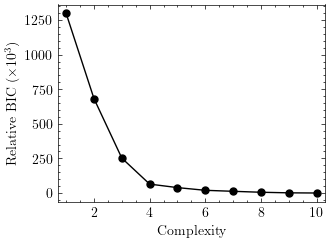

In [24]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [25]:
d_bic_scores, d_coms, _ = get_decreasing_vals(bic_scores, complexities)
find_transition_V2(d_bic_scores, d_coms, 0.099)
find_transition_V3(d_bic_scores, d_coms, 0.099)
find_transition_V4(d_bic_scores, d_coms, 0.099)
# bc = find_transition_V5(d_bic_scores, d_coms, 0.095)
bc = find_transition_V5(d_bic_scores, d_coms, 0.09, 0.01)

2 improves 1
Percent improve: 2.3412797393014078
3 improves 2
Percent improve: 1.2188554883731337 0.6982617857441533
4 improves 3
Percent improve: 0.24010557502941554 0.4370982270048325
5 does not improve 4
Percent improve: 0.025998013662324113
2 improves 1
Percent improve: 2.3412797393014078
3 improves 2
Percent improve: 1.2188554883731337 0.6982617857441533
4 improves 3
Percent improve: 0.24010557502941554 0.4370982270048325
5 does not improve 4
Percent improve: 0.025998013662324113
2 improves 1
Percent improve: 2.3412797393014078
3 improves 2
Percent improve: 1.2188554883731337 0.6982617857441533
4 improves 3
Percent improve: 0.24010557502941554 0.4370982270048325
5 does not improve 4
Percent improve: 0.025998013662324113
2 improves 1
Percent improve: 2.3412797393014078
3 improves 2
Percent improve: 1.2188554883731337
4 improves 3
Percent improve: 0.24010557502941554
5 does not improve 4
Percent improve: 0.025998013662324113


In [26]:
((wtr-newXr[:, br_u.track[bc][0]]@np.linalg.lstsq(newXr[:, br_u.track[bc][0]], wtr, rcond=None)[0])**2).mean()

0.0023061953597677334

In [27]:
errs = 100*np.abs(np.linalg.lstsq(newXr[:, br_u.track[bc][0]], wtr, rcond=None)[0].flatten()-ground_coeffs)/np.abs(ground_coeffs)
errs.mean(), errs.std()

(1.042223785677891, 0.22734982406002108)

In [28]:
bic_scores, complexities

(array([  262887.00792762,  -352605.01745888,  -782379.57821655,
         -970233.2767355 ,  -995457.41471971, -1014994.06845909,
        -1022207.71182469, -1029065.70283496, -1033251.95403   ,
        -1034490.14845235]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [29]:
pred = np.linalg.lstsq(newXr[:, br_u.track[bc][0]], wtr, rcond=None)[0]
print_pde(pred, 
          np.array(description)[list(br_u.track[bc][0])], ut = 'w_t')

w_t = (0.009927 +0.000000i)w_{xx}
    + (0.009886 +0.000000i)w_{yy}
    + (-0.990430 +0.000000i)uw_{x}
    + (-0.986591 +0.000000i)vw_{y}
   


In [30]:
pred

array([[ 0.00992737],
       [ 0.00988553],
       [-0.99043016],
       [-0.98659113]])

In [31]:
metric_dict = {'raw_bic_scores': bic_scores, 
               'rel_bic_scores': rel_bic_scores, 
               'complexities': complexities, 
               'min_bic_score': min_bic_score, 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'raw_bic_scores': array([  262887.00792762,  -352605.01745888,  -782379.57821655,
         -970233.2767355 ,  -995457.41471971, -1014994.06845909,
        -1022207.71182469, -1029065.70283496, -1033251.95403   ,
        -1034490.14845235]),
 'rel_bic_scores': array([1.29737716e+03, 6.81885131e+02, 2.52110570e+02, 6.42568717e+01,
        3.90327337e+01, 1.94960800e+01, 1.22824366e+01, 5.42444562e+00,
        1.23819442e+00, 0.00000000e+00]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_bic_score': -1034490.1484523542,
 'found_coeff': array([[ 0.00992737],
        [ 0.00988553],
        [-0.99043016],
        [-0.98659113]]),
 'percent_coefficient_error_mean': 1.042223785677891,
 'percent_coefficient_error_std': 0.22734982406002108}

In [32]:
file_name = f"./Visualization/nv_originalV2_clean.mat"
print(file_name)
sio.savemat(file_name, metric_dict)

./Visualization/nv_originalV2_clean.mat


In [22]:
# com: [1, 2, ..., 10]

# newcut, combine
# array([ -332355.44607765, -1035795.14538756, -1057091.36427579,
#        -1076639.62239269, -1082597.22430468, -1089590.5449716 ,
#        -1094282.40806104, -1096878.65510116, -1102794.45455926,
#        -1106311.92289121])
# newcut, uncombine
# array([  251110.64932581,  -333165.27467149,  -840972.20873175,
#        -1036207.88784906, -1059438.7461814 , -1077859.72577538,
#        -1083532.20071458, -1090186.68146309, -1094490.81171453,
#        -1088245.56928538])

# oldcut, combine
# array([ -349374.66981932,  -968971.59168413,  -992041.15314337,
#        -1013371.88401361, -1020348.44091455, -1027434.38564214,
#        -1032635.90280207, -1036111.54192447, -1038606.42694382,
#        -1043402.45129067])
# oldcut, uncombine
# array([  265432.17776937,  -350773.84091166,  -781272.27172945,
#         -969542.42013941,  -994869.46058713, -1014440.47018371,
#        -1021723.14013316, -1028539.3848122 , -1032692.26442869,
#        -1033833.82629057])